# Set up 

In [18]:
import numpy as np
import os
import sys


# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result
from model.plotfbd import plotfbd

In [ ]:
Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6) #kgm2
hull_surface_area = 0.0088 #m2
hull_cd = 1.2
hull_corr_factor = 0.75

r_xi = -111.76 * 10 ** (-3) #m 
r_zi = 0.722 * 10 ** (-3) #m

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10**(-3)
r_zt = -75 * 10**(-3)

rho = 1000 #kg/m3

# Aero foil parameters
AR = 2.61 #aspect ratio
area = 0.025 #Surface area
C_L_a = 0.1/np.deg2rad(1)
C_L_alpha_offset = 0.5
C_D_0 = 1.328/np.sqrt(200000)

## Initialize the models

In [20]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]),10,np.deg2rad(30))
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5),AR,area,C_L_a,C_L_alpha_offset,C_D_0)
hullForce = HullForce(hull_surface_area,np.array([r_xh,r_zh]))

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])

# Solve Equilibrium Point

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -8.00           degrees   
Delta_t         13.41           degrees   
Towing Force    98.07           N         
Delta_i         0.69            degrees   
----------------------
Fx:             0.00           N         
Fz:             -0.00          N         
My:             0.00           Nm        
Residual Norm: 0.000000
Optimization successful!


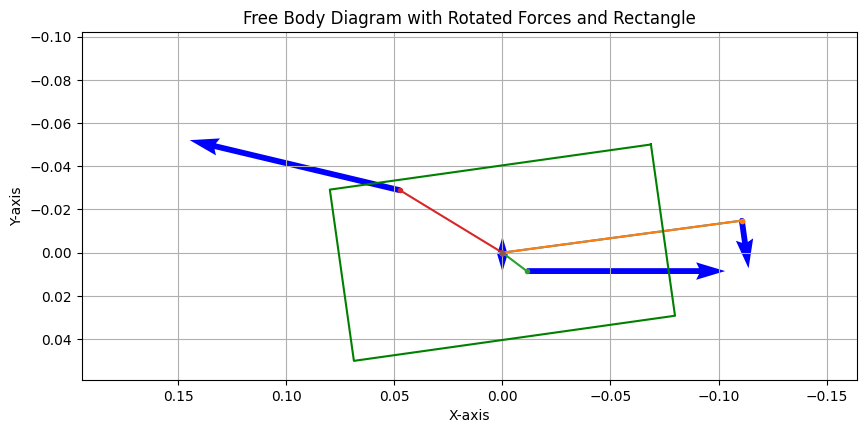

In [21]:
#Find equilibrium by minimizing Forces and moment individually using least squares
results_LS = sim.solve_equilibrium_state_LS(2)

initial_state = np.zeros(9)
initial_state[2] = results_LS[0]
initial_state[3] = 2

plotfbd(sim, sim.eq_sim)


# Equilibrium Simulation

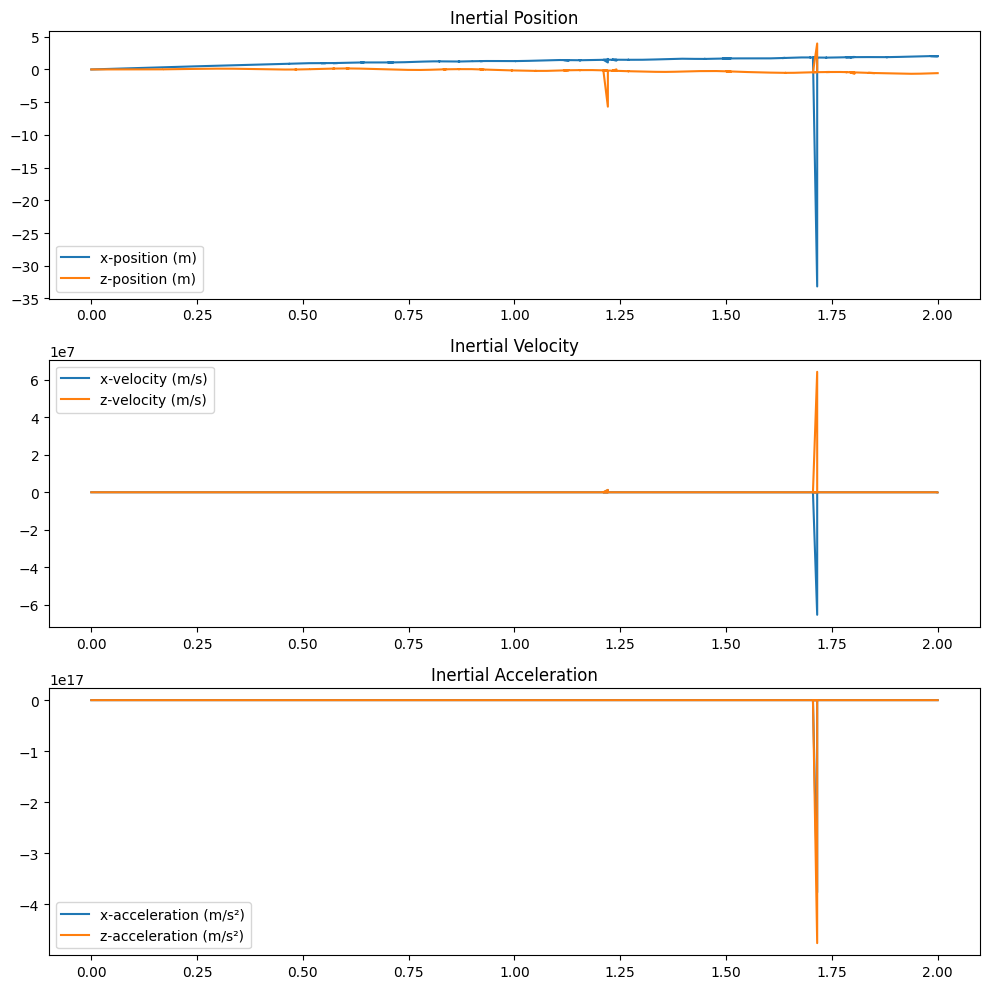

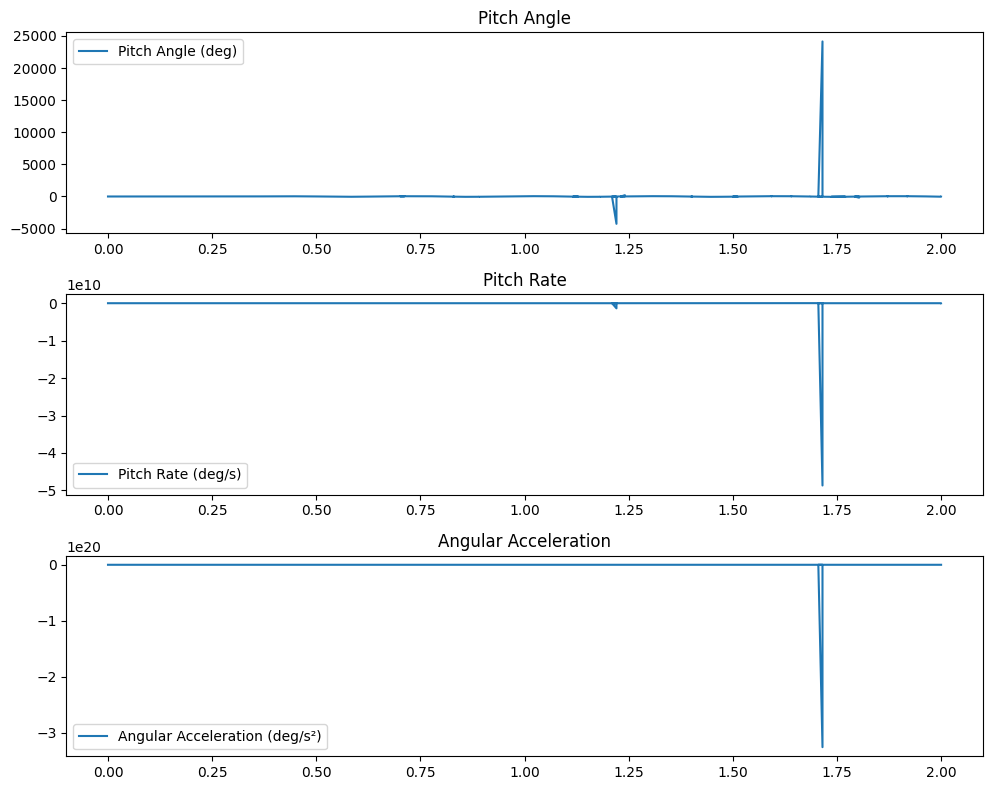

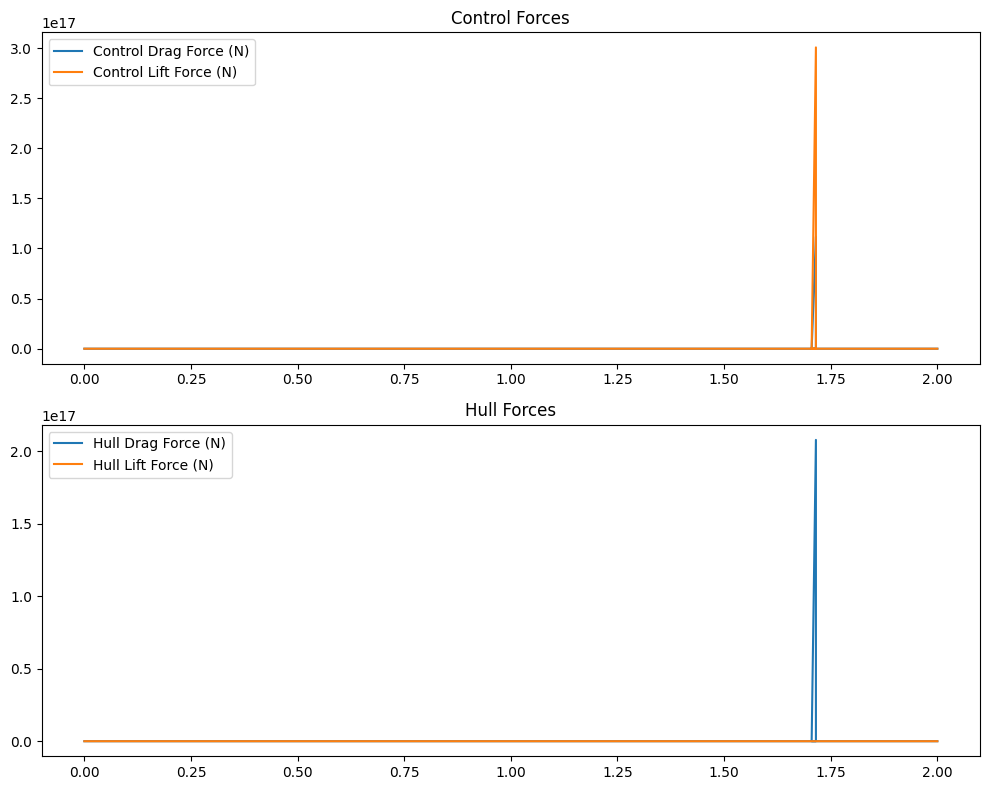

In [22]:
#print(initial_state)
sim_result_ivp, solution = sim.simulate_solve_ivp(200, 0.01, initial_state) ## RK45 Solver
sim_result_ivp.plot_simulation_results()

# Perturbation Simulation

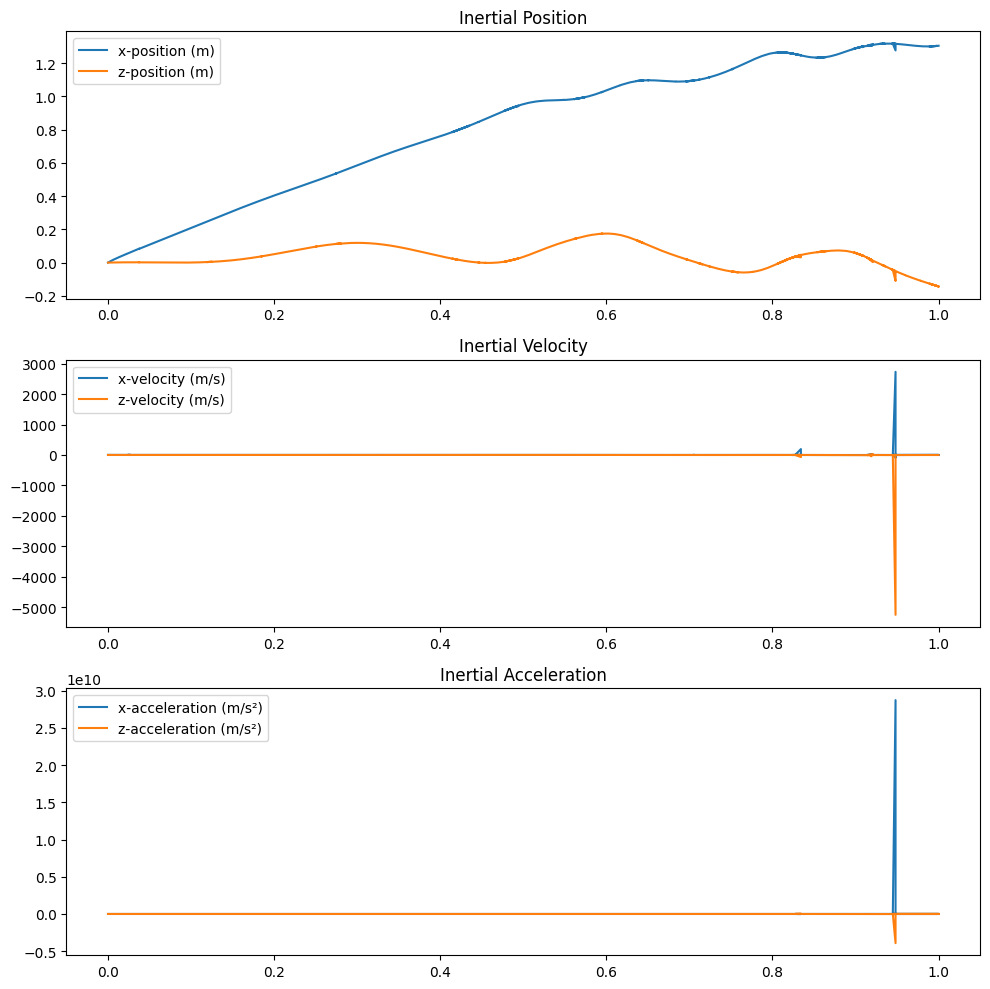

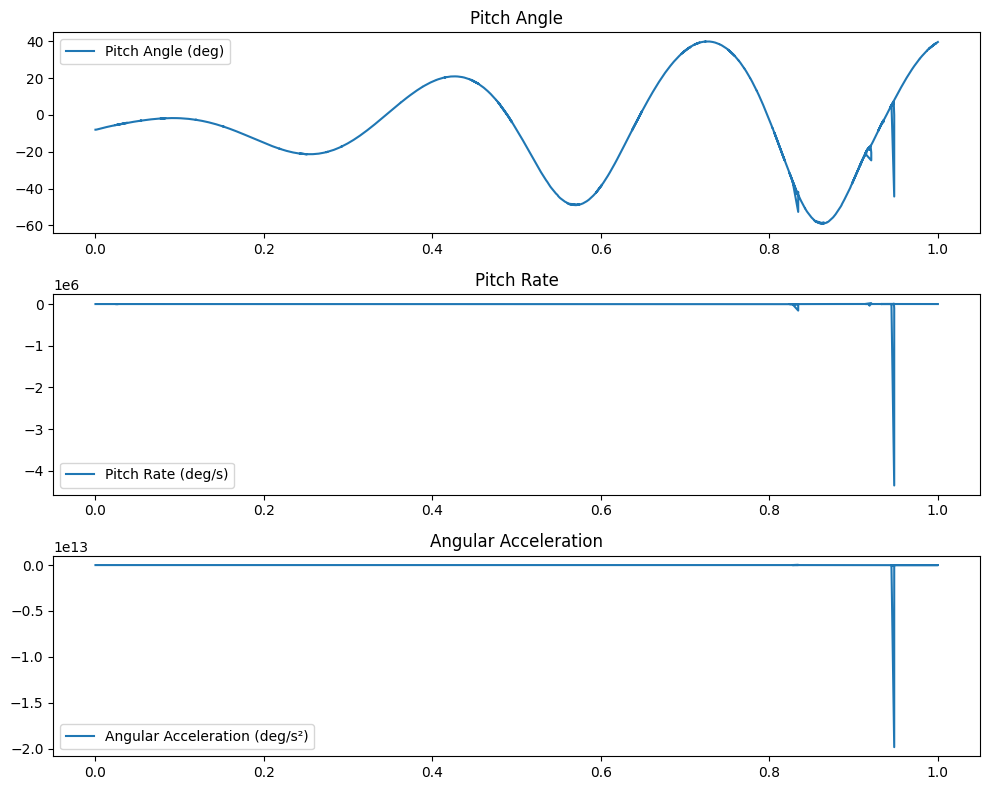

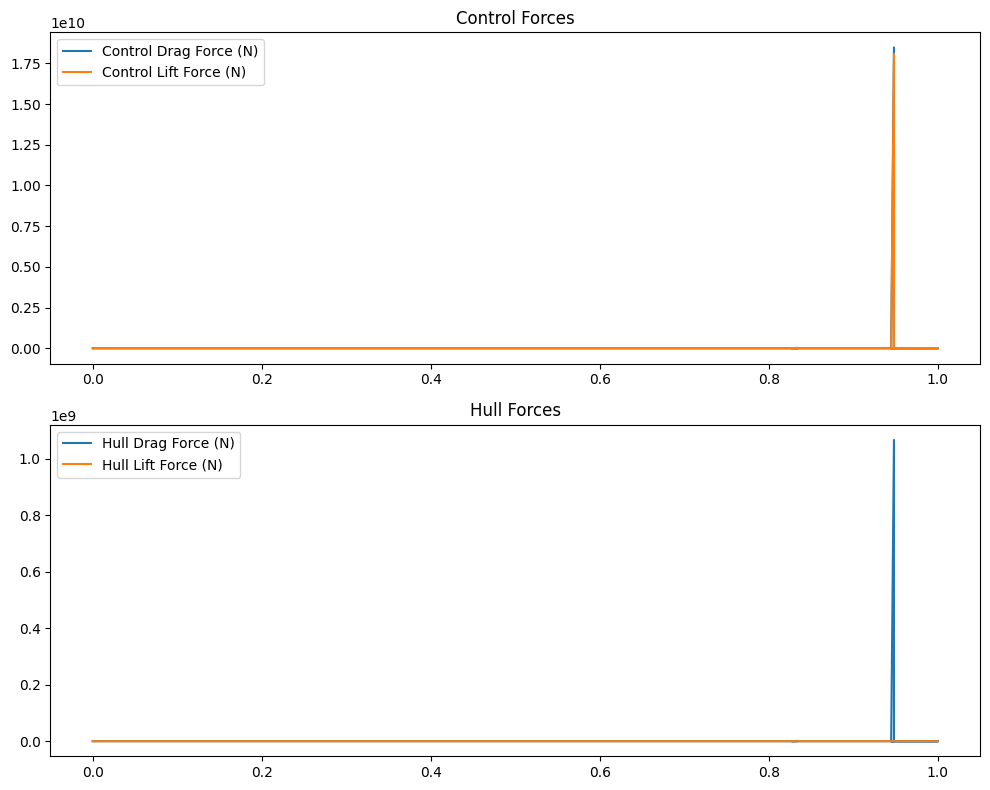

In [23]:
perturbed_state = np.copy(initial_state) 
perturbed_state[3] += 1 #Change Velocity

sim_result_ivp, solution = sim.simulate_solve_ivp(1000, 0.001, perturbed_state)
sim_result_ivp.plot_simulation_results()

# Jacobian & Eigenvalues

In [24]:
velocity = 2
pitch_angle = results_LS[0]
jacobian = sim.calculate_jacobian(velocity, pitch_angle, 1e-5)
eigs= np.linalg.eig(jacobian)
print(jacobian)

pstate [ 1.00000000e-05  0.00000000e+00 -1.39614938e-01  2.00000000e+00
  0.00000000e+00  0.00000000e+00]
xdot pertu [  2.           0.           0.          -6.10197058  42.1274133
 631.14734351]
pstate [ 0.00000000e+00  1.00000000e-05 -1.39614938e-01  2.00000000e+00
  0.00000000e+00  0.00000000e+00]
xdot pertu [  2.           0.           0.          -6.10197058  42.1274133
 631.14734351]
pstate [ 0.          0.         -0.13960494  2.          0.          0.        ]
xdot pertu [  2.           0.           0.          -6.1009763   42.12444024
 631.09183153]
pstate [ 0.          0.         -0.13961494  2.00001     0.          0.        ]
xdot pertu [  2.00001      0.           0.          -6.10311932  42.12807775
 631.15619122]
pstate [ 0.00000000e+00  0.00000000e+00 -1.39614938e-01  2.00000000e+00
  1.00000000e-05  0.00000000e+00]
xdot pertu [ 2.00000000e+00  1.00000000e-05  0.00000000e+00 -6.10180565e+00
  4.21258655e+01  6.31124272e+02]
pstate [ 0.00000000e+00  0.00000000e+00 -1.3